In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import polarTransform
from skimage.transform import match_histograms


model = tf.keras.models.load_model('matlab_mimicknet_small_ladj.h5')

W0916 04:08:34.655389 140492461332224 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [2]:
### load utils
# loadmat loads matlab files with dictionary support
# make_shape pads images to be divisible by 16
# scan_convert transforms images into cartesian space

def loadmat(filename):
    '''
    this function should be called instead of direct sio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], sio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def make_shape(image, shape=None, seed=0):
    np.random.seed(seed=seed)
    image_height = image.shape[0]
    image_width = image.shape[1]

    shape = shape if shape is not None else image.shape
    height = shape[0] if shape[0] % 16 == 0 else (16 - shape[0] % 16) + shape[0]
    width = shape[1] if shape[1] % 16 == 0 else (16 - shape[1] % 16) + shape[1]

    # Pad data to batch height and width with reflections, and randomly crop
    if image_height < height:
        remainder = height - image_height
        if remainder % 2 == 0:
            image = np.pad(image, ((int(remainder/2), int(remainder/2)), (0,0)), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((int(remainder/2) + 1, int(remainder/2)), (0,0)), 'reflect')
    elif image_height > height:
        start = np.random.randint(0, image_height - height)
        image = image[start:start+height, :]

    if image_width < width:
        remainder = width - image_width
        if remainder % 2 == 0:
            image = np.pad(image, ((0,0), (int(remainder/2), int(remainder/2))), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((0,0), (int(remainder/2) + 1, int(remainder/2))), 'reflect')
    elif image_width > width:
        start = np.random.randint(0, image_width - width)
        image = image[:, start:start+width]
    return image, (image_height, image_width)

def scan_convert(image, acq_params):
    # Takes an image (r, theta), and acq_params dictionary
    r = acq_params['r']
    apex = acq_params['apex'] if 'apex' in acq_params else acq_params['apex_coordinates'][2]
    theta = acq_params['theta']
    initial_radius = abs((r[0] - apex)/(r[1]-r[0]))
    image, _ = polarTransform.convertToCartesianImage(
        np.transpose(image),
        initialRadius=initial_radius,
        finalRadius=initial_radius+image.shape[0],
        initialAngle=theta[0],
        finalAngle=theta[-1],
        hasColor=False,
        order=3)
    return np.transpose(image[:, int(initial_radius):])

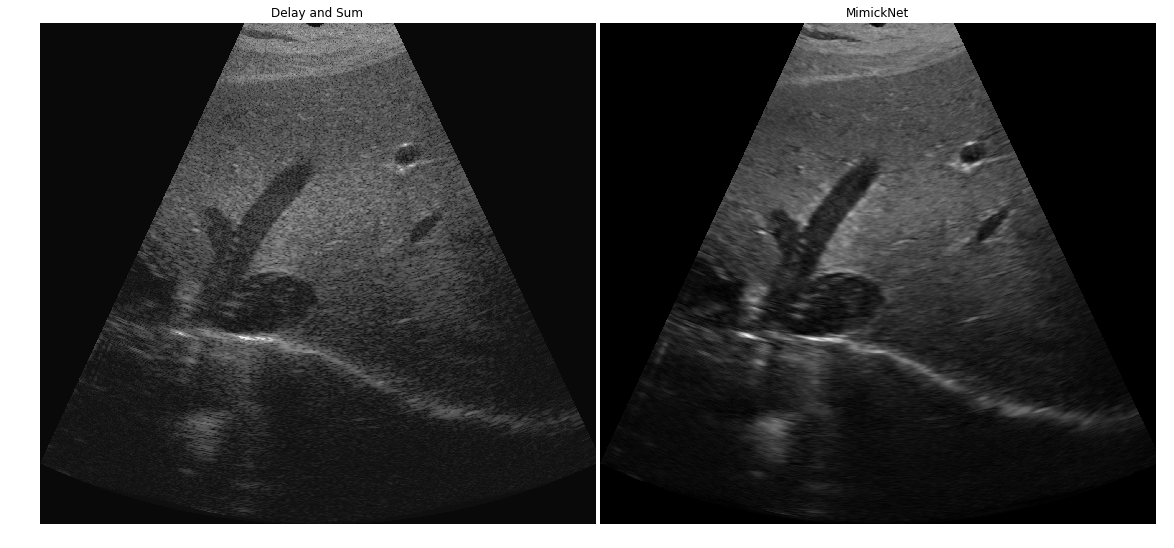

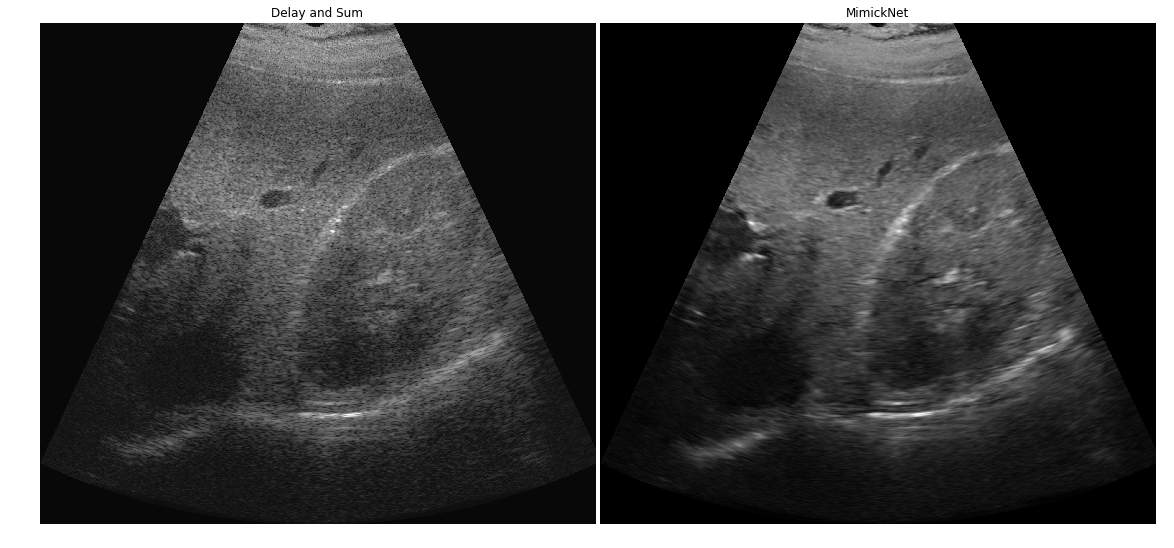

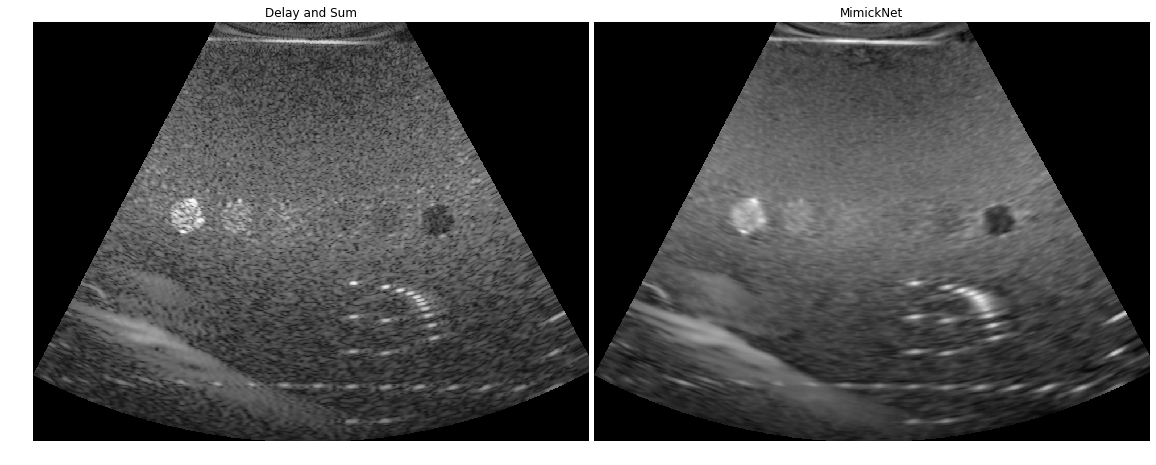

In [4]:
# liver and kidney donated in kind by the M.L.P.
for file in ['mark_liver.mat', 'mark_kidney.mat', 'phantom.mat']:    
    # Load raw beamformed data and ground truth
    matfile = loadmat(file)
    iq = np.abs(matfile['iq'])
    iq = 20*np.log10(iq/iq.max())

    # Prep Model inputs and get output
    iq = np.clip(iq, -80, 0)
    iq = (iq-iq.min())/(iq.max() - iq.min()) # Normalize to [0, 1]
    padded_iq, (original_height, original_width) = make_shape(iq) # Pad data to be divisible by 16 
    padded_iq = padded_iq[None, :, :, None] # Reshape to be 4D [batch, height, width, 1]
    output = model.predict(padded_iq) # Run through the model 
    output = (output-output.min())/(output.max() - output.min())
    output = np.squeeze(output)[:original_height, :original_width] # Reshape to original size
    iq = match_histograms(iq, output)

    iq = scan_convert(iq, matfile['acq_params'])
    output = scan_convert(output, matfile['acq_params'])

    # Plot Figure
    fig, axes = plt.subplots(1,2, figsize=(20,20), gridspec_kw={
        'wspace': 0.01,
        'hspace': 0
    })
    axes[0].imshow(iq, cmap='gray')
    axes[0].set_title('Delay and Sum')
    axes[0].axis('off')
    
    axes[1].imshow(output, cmap='gray')
    axes[1].set_title('MimickNet')
    axes[1].axis('off')